In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### Importing Training Data  

In [ ]:
import array
def load_images(filename):
    f = open(filename, 'rb')

    sig = f.read(4)
    dim1 = int.from_bytes(f.read(4), byteorder='big', signed=False)
    dim2 = int.from_bytes(f.read(4), byteorder='big', signed=False)
    dim3 = int.from_bytes(f.read(4), byteorder='big', signed=False)

    data = np.array(array.array('B', f.read()))
    result = data.reshape(dim1, dim2, dim3)

    f.close()

    return result


def load_labels(filename):
    f = open(filename, 'rb')

    sig = f.read(4)
    dim1 = int.from_bytes(f.read(4), byteorder='big', signed=False)

    result = np.array(array.array('B', f.read()))

    f.close()

    return result



In [ ]:
images = load_images('/train-images-idx3-ubyte') # 60,000 images
labels = load_labels('/train-labels-idx1-ubyte')

In [ ]:
def lineariseImage(image):
    return image.reshape(784)

In [ ]:
# training data is the pair of linearised images and their labels
training_data = [(lineariseImage(image), label) for image, label in zip(images, labels)]

### Task 1: Plotting the Average Image

In [ ]:
def averageImage():
    sum_images = np.zeros(784)
    for image, _ in training_data:
        sum_images += image
    return sum_images / len(training_data)

def plot(linear_image):
    plt.imshow(linear_image.reshape(28, 28))
    plt.show()

def plot_gray(linear_image):
    plt.imshow(linear_image.reshape(28, 28), cmap='gray')
    plt.show()

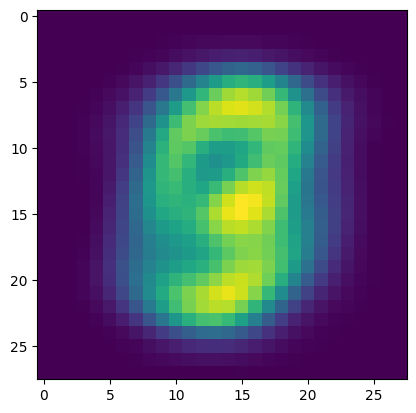

In [ ]:
plot(averageImage())

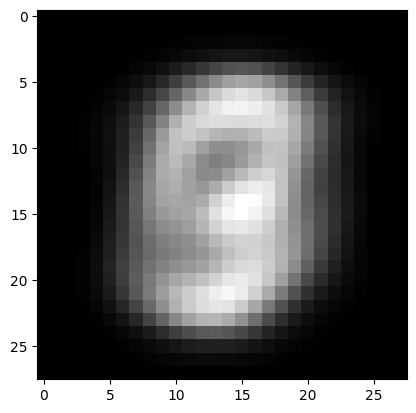

In [ ]:
plot_gray(averageImage())

### Stochastic Gradient Descent

In [ ]:
class Model:

    def __init__(self, training_data, alpha, epochs=10):
        self.training_data = training_data
        self.alpha = alpha
        self.epochs = epochs
        self.W = np.zeros((784, 10))

    def logsumexp(self, x):
        c = x.max()
        return c + np.log(np.sum(np.exp(x - c)))

    # softmax with logsumexp trick to avoid overflow and underflow
    def softmax_logsumexp(self, output_layer):
        return np.exp(output_layer - self.logsumexp(output_layer))

    # feedforward function
    def feedForward(self, image):
        linearised_image = lineariseImage(image) # 784, 1 vector
        output_layer = np.array(np.dot(self.W.T, linearised_image)).flatten() # output layer is w^T * x
        probabilities = self.softmax_logsumexp(output_layer)  # softmax function on the output layer to get the probabilities
        return probabilities

    # given the ground truth, calculate the log loss
    def logLoss(self, probabilities, label):
        return -np.log(probabilities[label] + 1e-10)

    def avgLogLoss(self):
        avg_loss = 0
        for image, label in self.training_data:
            avg_loss += self.logLoss(self.feedForward(image), label)
        avg_loss = avg_loss / len(self.training_data)
        return avg_loss

    def update_weights(self, image, ground_truth, learning_rate):
        # create a new (784, 10) matrix to store the updates
        updates = np.zeros((784, 10))
        probabilities = self.feedForward(image)
        for digit in range(10):
            if digit == ground_truth:
                updates[:, digit] = (probabilities[digit] - 1) * image
            else:
                updates[:, digit] = probabilities[digit] * image

        self.W = self.W - learning_rate * updates

    def epoch(self):
        for sample in self.training_data:
            image, ground_truth = sample
            self.update_weights(image, ground_truth, self.alpha)

    def SGD(self):
        avg_loss_history = []
        for i in range(self.epochs):
            avg_loss = self.avgLogLoss()
            avg_loss_history.append(avg_loss)
            self.epoch()
        avg_loss = self.avgLogLoss()
        avg_loss_history.append(avg_loss)
        return avg_loss_history, self.W

### Testing SGD Model for Range of Learning Rates

In [ ]:
# saving the loss history for a range of learning rates
loss_histories = {}
model_histories = {}
learning_rates = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
for alpha in learning_rates:
    model = Model(training_data, alpha)
    loss_histories[alpha], model_histories[alpha] = model.SGD()

### Visualising the Average Loss over Training Epochs

In [ ]:
def plot_loss(learning_rates, loss_histories):
    plt.figure(figsize=(10, 6))

    for lr in learning_rates:
        loss_array = loss_histories[lr]
        epochs = list(range(len(loss_array)))
        plt.plot(epochs, loss_array, marker='o', label=f'LR={lr}')  # Added marker here

    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Average Loss per Epoch for Different Learning Rates')
    plt.xticks(range(11))  # Set x-axis ticks to show every epoch from 0 to 10
    plt.legend()
    plt.grid(True)
    plt.show()

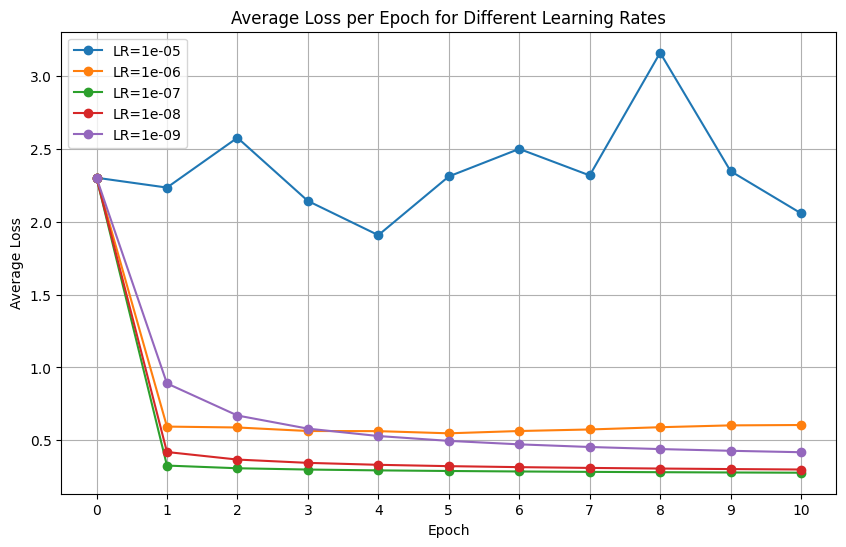

In [ ]:
plot_loss(learning_rates, loss_histories)

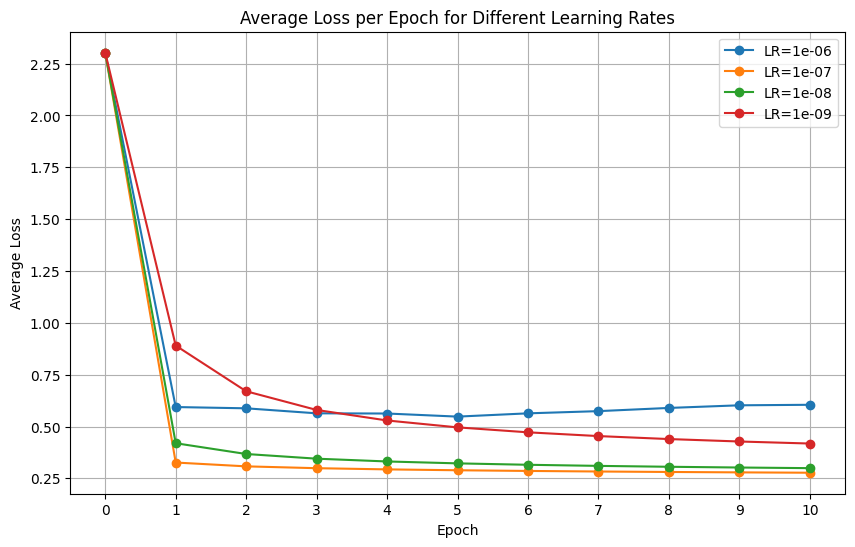

In [ ]:
plot_loss(learning_rates[1:], loss_histories)

### Evaluating Classifiers with Zero-One Loss

- yˆ = argmax wy⊤x (26) y∈{0,...,9} for predicition
- zero one loss for loss

In [ ]:
# getting in the t10k data
images = load_images('/content/t10k-images-idx3-ubyte') # 60,000 images
labels = load_labels('/content/t10k-labels-idx1-ubyte')


In [ ]:
# training data is the pair of linearised images and their labels
training_data = [(lineariseImage(image), label) for image, label in zip(images, labels)]

In [ ]:
# takes in the
def zero_one_loss(training_data, classifier):
  total_loss = 0
  W = classifier # classifier is just the weights matrix
  for image, label in training_data:
    # get the predicted label of the image from the classifier
    output_layer = np.array(np.dot(W.T, image)).flatten()
    # prediction is the argmax of the output_layer
    y_pred = np.argmax(output_layer)
    zero_one_loss = 1 if y_pred != label else 0
    total_loss += zero_one_loss

  return total_loss


In [ ]:
# retrieve the best classifier (1e-7)
classifier = model_histories[1e-7]
total_loss = zero_one_loss(training_data, classifier)


In [ ]:
learning_rate_losses = [zero_one_loss(training_data, model_histories[alpha]) for alpha in learning_rates ]


### Bar charts for the Zero One Loss for Each of the Classifiers

In [ ]:
import matplotlib.cm as cm

def zero_one_loss_bar_chart(training_data, learning_rates, model_histories, zero_one_loss):
    # Indices for the learning rates
    indices = np.arange(len(learning_rates))

    # learning rate zero-one losses
    y = [zero_one_loss(training_data, model_histories[alpha]) for alpha in learning_rates]

    # Generate a color map
    colors = cm.rainbow(np.linspace(0, 1, len(learning_rates)))

    # plot bar charts for each of the learning rates with the zero one loss
    plt.figure(figsize=(12, 6))
    bars = plt.bar(indices, y, color=colors, alpha=0.7)

    # Add text on top of each bar
    for bar, loss in zip(bars, y):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., 1.01*height, f'{loss:.2f}', ha='center', va='bottom')

    plt.xlabel('Learning Rate')
    plt.ylabel('Zero-One Loss')
    plt.title('Zero-One Loss for Different Learning Rates')
    plt.xticks(indices, labels=[f'{lr:.1e}' for lr in learning_rates])  # Use scientific notation for learning rates
    plt.grid(True, axis='y')  # Grid only on the y-axis
    plt.show()

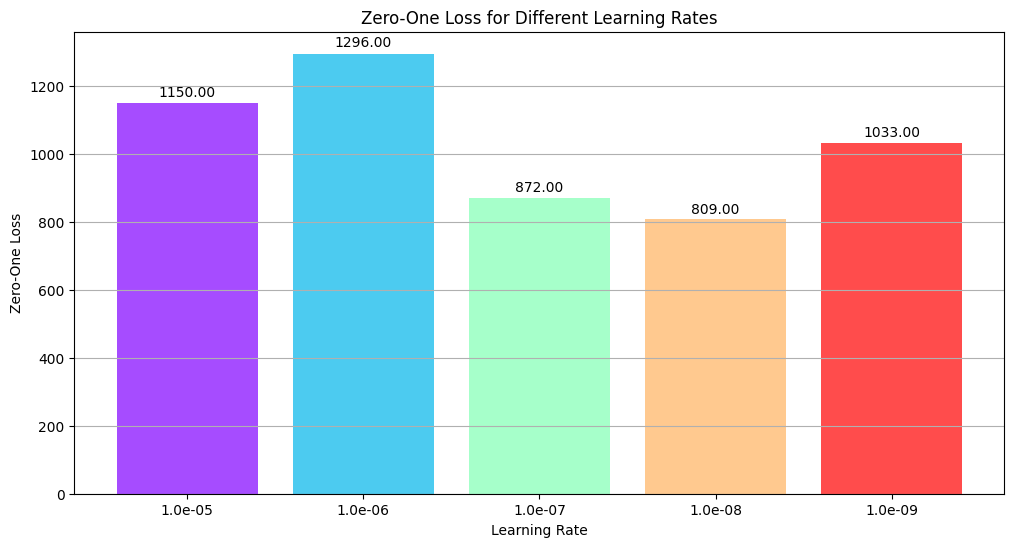

In [ ]:
zero_one_loss_bar_chart(training_data, learning_rates, model_histories, zero_one_loss)